## Part 3: Doing GIS and spatial data analysis in Python

In [ ]:
!pip install pygris[explore] libpysal esda spopt splot

In [2]:
from pygris.geocode import geocode

geocode("426 Thompson St, Ann Arbor MI 48106")

,longitude,latitude,GEOID,address
0,-83.743206,42.277354,261614005007001,"426 Thompson St, Ann Arbor MI 48106"


In [3]:
ssdan = geocode("426 Thompson St, Ann Arbor MI 48106", as_gdf = True)

ssdan.explore(marker_type = "marker")

In [5]:
from pygris import tracts

ssdan_tracts = tracts(state = "MI", cb = True, 
                      subset_by = {"426 Thompson St, Ann Arbor MI 48106": 5000})
                      
ssdan_tracts.explore()

Using the default year of 2021
Using FIPS code '26' for input 'MI'


Using the default year of 2021
Using FIPS code '20' for input 'KS'
Using the default year of 2021
Using FIPS code '29' for input 'MO'
Using the default year of 2021


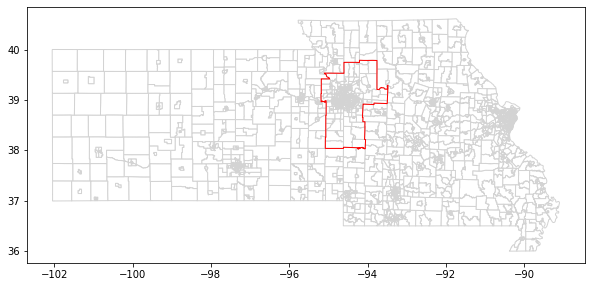

In [6]:
import pandas as pd
import matplotlib.pyplot as plt
from pygris import core_based_statistical_areas

ks_mo_tracts = pd.concat([tracts(state = x, cb = True) for x in ["KS", "MO"]])

kc_metro = core_based_statistical_areas(cb = True).query("GEOID == '28140'")

fig, ax = plt.subplots(figsize = (10, 10))

ks_mo_tracts.plot(color = "white", edgecolor = "lightgrey", ax = ax)
kc_metro.plot(edgecolor = "red", facecolor = "none", ax = ax)

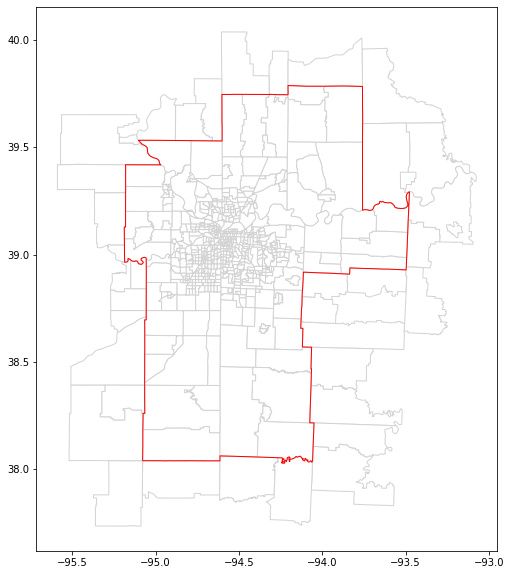

In [7]:
kc_intersects = ks_mo_tracts.intersects(kc_metro.geometry.iloc[0])

kc_tracts = ks_mo_tracts.loc[kc_intersects]

fig, ax = plt.subplots(figsize = (10, 10))

kc_tracts.plot(color = "white", edgecolor = "lightgrey", ax = ax)
kc_metro.plot(edgecolor = "red", facecolor = "none", ax = ax)

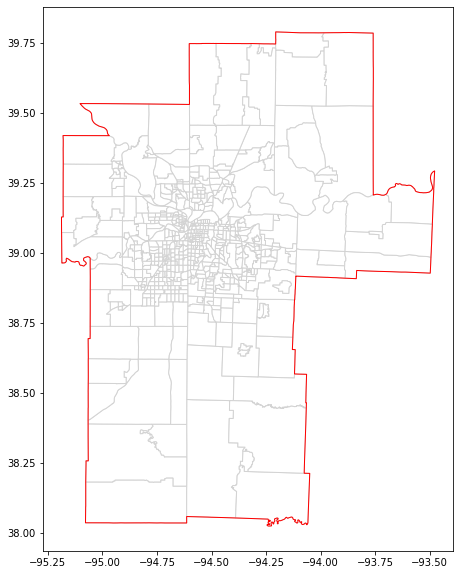

In [8]:
kc_within = ks_mo_tracts.within(kc_metro.geometry.iloc[0])

kc_tracts_within = ks_mo_tracts.loc[kc_within]

fig, ax = plt.subplots(figsize = (10, 10))

kc_tracts_within.plot(color = "white", edgecolor = "lightgrey", ax = ax)
kc_metro.plot(edgecolor = "red", facecolor = "none", ax = ax)

In [9]:
from pygris.data import get_census

vars = ["DP02_0068PE", "DP04_0007PE", "DP05_0018E"]

metrics = get_census(dataset = "acs/acs5/profile",
                     variables = vars,
                     year = 2021,
                     params = {
                       "for": "tract:*",
                       "in": "state:20,29"},
                     guess_dtypes = True,
                     return_geoid = True)

In [10]:
kc_metrics = kc_tracts_within.merge(metrics, on = "GEOID").fillna(0)

/usr/local/lib/python3.8/dist-packages/splot/_viz_libpysal_mpl.py:115: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  centroids_shp = gdf.centroid.values
/usr/local/lib/python3.8/dist-packages/splot/_viz_libpysal_mpl.py:154: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf.centroid.plot(ax=ax, **node_kws)


(<Figure size 720x720 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f65a5c16c10>)

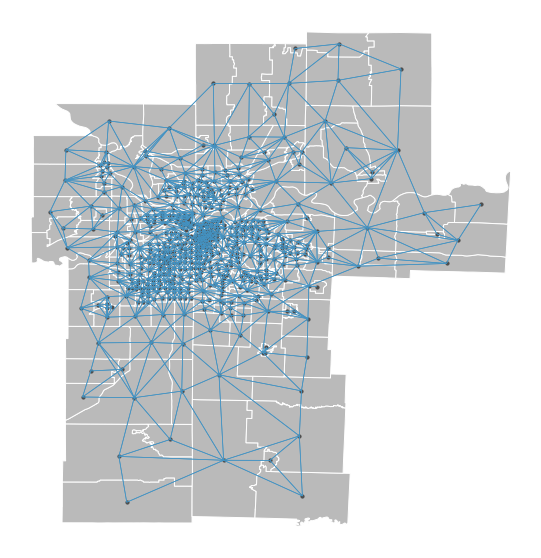

In [11]:
from libpysal import weights
from splot.libpysal import plot_spatial_weights

w = weights.contiguity.Queen.from_dataframe(kc_metrics)

plot_spatial_weights(w, kc_metrics)

In [13]:
from spopt.region import Skater
import numpy
numpy.random.seed(1983)

skater_model = Skater(
    kc_metrics,
    w,
    attrs_name = vars,
    n_clusters = 10,
    floor = 10
)

skater_model.solve()

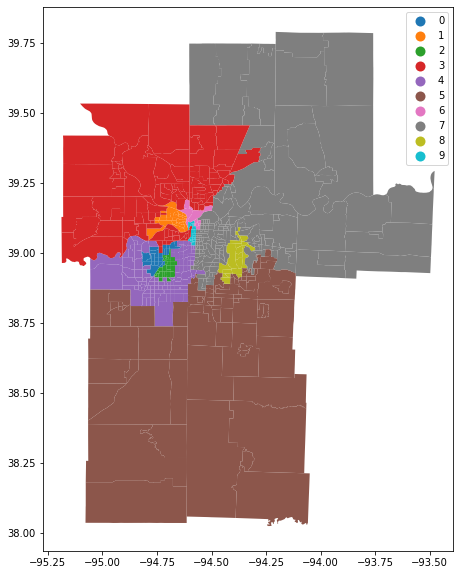

In [14]:
kc_metrics['Region'] = skater_model.labels_

kc_metrics.plot(column = "Region", categorical = True, figsize = (8, 10),
                legend = True)